In [1]:
#Download HSI Data
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2023-04-06 03:29:40--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat [following]
--2023-04-06 03:29:41--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M   141KB/s    in 3m 0s   

2023-04-06 03:32:41 (189 KB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2023-04-06 03:32:41--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 O

In [3]:
!ls

PaviaU_gt.mat  PaviaU.mat  sample_data


In [21]:
# Importing librar 
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from keras.models import Sequential, Model
from sklearn.svm import SVC    
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report)
from tensorflow.keras.models import load_model, Sequential
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm
from time import time
from keras.layers import Activation, Dense, Dropout
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Input
from keras.utils import to_categorical
from numpy.random import seed
seed(11)

In [22]:
# Load hyperspectral data and ground_truth
data =loadmat('PaviaU.mat')['paviaU']
gt=loadmat('PaviaU_gt.mat')['paviaU_gt']
print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (610, 340)
Number of Bands: 103


In [23]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()

In [24]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [59]:
X = df[df['class']!=0].iloc[:, :-1].values
y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)

print(f"Train Data: {X_train.shape}\nTest Data: {X_test.shape}")

Train Data: (29943, 103)
Test Data: (12833, 103)


In [27]:
# convolutional layers

model = Sequential(name='cnn')

model.add(Input(shape=(X_train.shape[1], 1), name='Input_Layer'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Conv_Layer1'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Conv_Layer2'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling1'))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='Conv_Layer3'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='Conv_Layer4'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling2'))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', name='Conv_Layer5'))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', name='Conv_Layer6'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling3'))

model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(units=512, activation='relu', name='Layer1'))
model.add(Dropout(rate=0.2, name='Dropout1'))
model.add(Dense(units=256, activation='relu', name='Layer2'))
model.add(Dropout(rate=0.2, name='Dropout2'))
model.add(Dense(units=128, activation='relu', name='Layer3'))
model.add(Dropout(rate=0.2, name='Dropout3'))

model.add(Dense(units=y_train.shape[1], activation='softmax', name='Output_Layer'))

In [28]:
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_Layer1 (Conv1D)        (None, 101, 64)           256       
                                                                 
 Conv_Layer2 (Conv1D)        (None, 99, 64)            12352     
                                                                 
 MaxPooling1 (MaxPooling1D)  (None, 49, 64)            0         
                                                                 
 Conv_Layer3 (Conv1D)        (None, 47, 128)           24704     
                                                                 
 Conv_Layer4 (Conv1D)        (None, 45, 128)           49280     
                                                                 
 MaxPooling2 (MaxPooling1D)  (None, 22, 128)           0         
                                                                 
 Conv_Layer5 (Conv1D)        (None, 20, 256)           98560   

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)


tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [31]:
# train the network
history =model.fit(X_train,y_train, epochs =29, batch_size = 32,validation_data = (X_test, y_test), callbacks=[early_stop,checkpoint,tensorboard])
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/29
936/936 [==============================] - 98s 101ms/step - loss: 0.9445 - accuracy: 0.6763 - val_loss: 0.5491 - val_accuracy: 0.7913
Epoch 2/29
936/936 [==============================] - 90s 96ms/step - loss: 0.5423 - accuracy: 0.7883 - val_loss: 0.3619 - val_accuracy: 0.8611
Epoch 3/29
936/936 [==============================] - 89s 95ms/step - loss: 0.4008 - accuracy: 0.8435 - val_loss: 0.3415 - val_accuracy: 0.8590
Epoch 4/29
936/936 [==============================] - 89s 95ms/step - loss: 0.3461 - accuracy: 0.8690 - val_loss: 0.2867 - val_accuracy: 0.8860
Epoch 5/29
936/936 [==============================] - 86s 92ms/step - loss: 0.3180 - accuracy: 0.8804 - val_loss: 0.2496 - val_accuracy: 0.9031
Epoch 6/29
936/936 [==============================] - 85s 91ms/step - loss: 0.2810 - accuracy: 0.8919 - val_loss: 0.2356 - val_accuracy: 0.9093
Epoch 7/29
936/936 [==============================] - 86s 92ms/step - loss: 0.2574 - accuracy: 0.9024 - val_loss: 0.2168 - val_accuracy

In [61]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

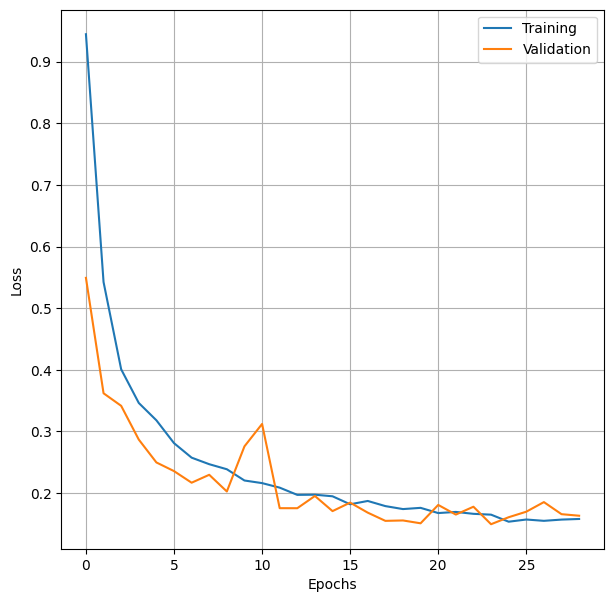

In [62]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()

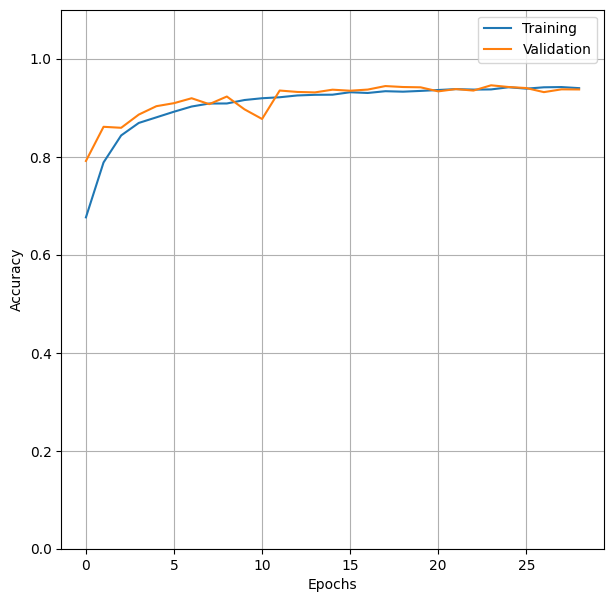

In [63]:
plt.figure(figsize=(7,7)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [64]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 93.72711181640625
Loss: 0.16318269073963165


# Support Vector Machine (SVM)

In [65]:
# Extract features using the trained CNN
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-4].output)
x_train_features = feature_extractor.predict(X_train)
x_test_features = feature_extractor.predict(X_test)
svm = SVC(kernel='linear')
svm.fit(x_train_features, np.argmax(y_train, axis=1))
svm_score = svm.score(x_test_features, np.argmax(y_test, axis=1))
print("SVM accuracy:", svm_score)

402/402 [==============================] - 7s 17ms/step
SVM accuracy: 0.9616613418530351


# Validation

In [66]:
# Predict labels for the test set
y_pred = svm.predict(x_test_features)
# Convert one-hot encoded labels to integers
y_test = np.argmax(y_test, axis=1)
# Compute classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           1       0.97      0.97      0.97      1989
           2       0.98      0.98      0.98      5595
           3       0.90      0.84      0.87       630
           4       0.98      0.97      0.98       919
           5       1.00      1.00      1.00       403
           6       0.94      0.94      0.94      1509
           7       0.95      0.91      0.93       399
           8       0.88      0.94      0.91      1105
           9       1.00      1.00      1.00       284

    accuracy                           0.96     12833
   macro avg       0.96      0.95      0.95     12833
weighted avg       0.96      0.96      0.96     12833



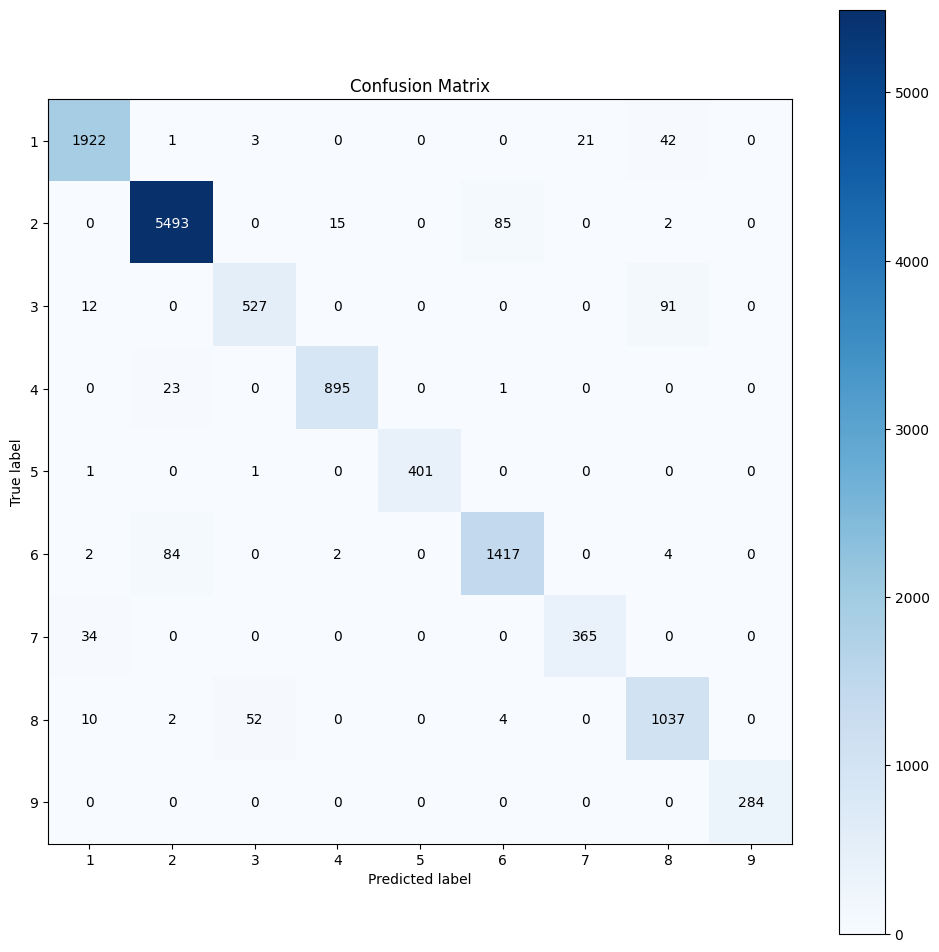

In [67]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12));

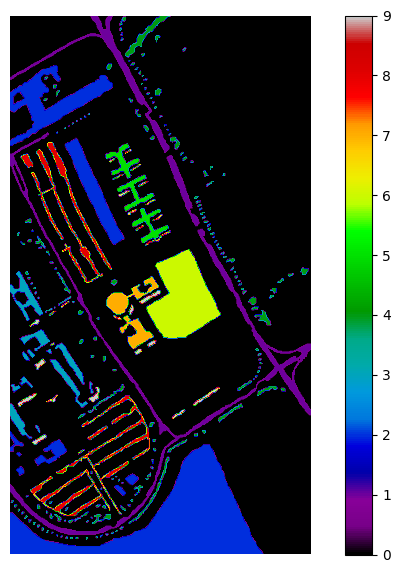

In [20]:
def plot_data(data):
  fig = plt.figure(figsize=(9, 7))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
plot_data(gt)

100%|██████████| 207400/207400 [37:46<00:00, 91.49it/s]  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



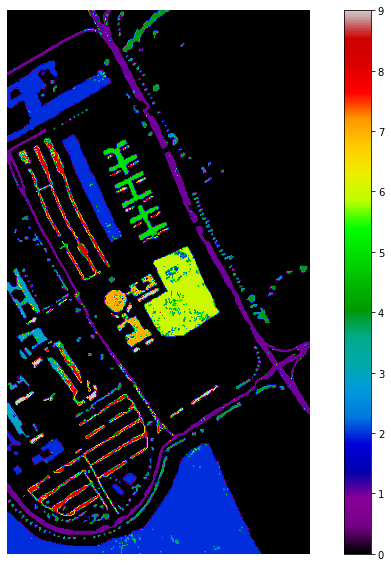

In [ ]:
l = []
for i in tqdm(range(df.shape[0])):
  if df.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(np.argmax(model.predict(df.iloc[i, :-1].values.reshape(-1, 103)), 1))
q = np.array(l).reshape(gt.shape).astype('float')
plot_data(q)